<a href="https://www.kaggle.com/code/ippeiogawa/jux-ppo-training-based-on-purejaxrl?scriptVersionId=145820693" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Jux PPO training based on PureJaxRL https://github.com/luchris429/purejaxrl

> **PureJaxRL is inspired by CleanRL, providing high-quality single-file implementations with research-friendly features. Like CleanRL, this is not a modular library and is not meant to be imported. The repository focuses on simplicity and clarity in its implementations, making it an excellent resource for researchers and practitioners.

With so much struggle with Jax, I created a training loop of a simple environment.
* one heavy robot per factory.
* factories are randomly placed adjacent to ice.
* 12 actions ;
        [do_nothing,
        move_up, move_right, move_down, move_left,
        transfer_ice_center, transfer_ice_up, transfer_ice_right, transfer_ice_down, transfer_ice_left,
        pickup_power, dig]
* no factory action except for building heavy at the begining.
* 9 ovservations :
        [map.ice,
          map.rubble/100,
          unit_map,
          unit_power_map/3000,
          unit_cargo_ice_map/1000,
          enemy_unit_map,
          factory_occupancy_map/127,
          factory_power_map/5000,
          enemy_factory_occupancy_map/127]


Network is based on https://github.com/RoboEden/lux2-deimos/tree/372a430c8ca06454f6591e9f5d4b0ab505420fea

jax.jit the whole process need some amendments, but so far I found no improvement in speed with jitting.

Using fixed valid_spawn_mask.

Action maskings(e.g. No dig on factory) are mapped and stacked with observation, then transferred to network.

Not sure about logprob of multi agent actions and just summed up each agent's logprob.


In [1]:
import optax # need to import here before numpy1.25.2installing

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from IPython.display import clear_output as clr
!pip install numpy==1.25.2 # to install distrax and gymnax
clr()

In [3]:
!pip install distrax
!pip install gymnax
clr()

In [4]:
# we need to use a lower version of jax for environment generation. Does not affect normal RL inference code
%pip install --upgrade "jax[cuda11_cudnn82]==0.4.7" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# install the package. For now this is from source, the final pypi package will be released soon
%pip install git+https://github.com/RoboEden/jux.git@dev
# rich is needed by this tutorial for nice printing
%pip install rich
clr()

In [5]:
!pip install jax==0.4.14 # for orbax.checkpoint and jux avoiding restart
clr()

In [6]:
import jax
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState

In [7]:
import distrax
import gymnax
# from gymnax.wrappers.purerl import LogWrapper, FlattenObservationWrapper
from gymnax.environments import environment, spaces
from flax import struct
import rich
import gc

In [8]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform) # to check if gpu is used. Sometimes not after Keyboard Interrupt or in some occasions.

gpu


In [9]:
from jux.env import JuxEnv
from jux.config import JuxBufferConfig, EnvConfig
from jux.actions import JuxAction

jux_env = JuxEnv(
    env_cfg=EnvConfig(),
    buf_cfg=JuxBufferConfig(MAX_N_UNITS=200),
)

# jux_env.buf_cfg

In [10]:
msize = jux_env.buf_cfg.MAP_SIZE
max_n_fac = jux_env.buf_cfg.MAX_N_FACTORIES
max_n_units = jux_env.buf_cfg.MAX_N_UNITS

In [11]:
from jux.env import JuxEnvBatch
# jux_env_batch = JuxEnvBatch(env_cfg=EnvConfig(max_episode_length=40),buf_cfg=JuxBufferConfig(MAX_N_UNITS=200))

In [12]:
class SELayer(nn.Module):
    channel: int
    reduction: int = 4#16

    @nn.compact
    def __call__(self, x):
        b, h, w, c = x.shape
        y = jnp.mean(x, axis=(-3, -2), keepdims=True)
        y = nn.Dense(self.channel // self.reduction, kernel_init=orthogonal(np.sqrt(2)))(y)
        y = nn.relu(y)
        y = nn.Dense(self.channel, kernel_init=orthogonal(np.sqrt(2)))(y)
        y = nn.sigmoid(y)
        y = jnp.transpose(y,(0,3,1,2))
        y = jnp.tile(y,(h,w))
        y = jnp.transpose(y,(0,2,3,1))
        return x * y


In [13]:
class ResidualBlock(nn.Module):
    in_channel: int
    out_channel: int
    kernel_size: int = 5
    padding: int = 2

    @nn.compact
    def __call__(self, x):
        left = nn.Conv(self.out_channel,
                       kernel_size=(self.kernel_size, self.kernel_size),
                       padding=(self.padding, self.padding),
                       kernel_init=orthogonal(np.sqrt(2)),
                      )(x)
        left = nn.leaky_relu(left)
        left = nn.Conv(self.out_channel,
                       kernel_size=(self.kernel_size, self.kernel_size),
                       padding=(self.padding, self.padding),
                       kernel_init=orthogonal(np.sqrt(2)),
                      )(left)
        left = nn.leaky_relu(left)
        selayer = SELayer(self.out_channel)
        out = selayer(left)
        out = out + x
        out = nn.leaky_relu(out)
        return out


In [14]:
class Net(nn.Module):
    features: int
    num_act: int

    @nn.compact
    def __call__(self, map_feature, unit_pos):
        B, H, W, C = map_feature.shape
        n_mask = C - self.features
        action_mask = map_feature[:,:,:,-n_mask:]
        map_feature = map_feature[:,:,:,:-n_mask]
        x = nn.Conv(features=self.features, kernel_size=(1, 1),
                    kernel_init=orthogonal(np.sqrt(2)))(map_feature)
        x = nn.leaky_relu(x)
        x = nn.Conv(features=self.features, kernel_size=(1, 1),
                    kernel_init=orthogonal(np.sqrt(2)))(x)
        x = nn.leaky_relu(x)

        for _ in range(4):
            x = ResidualBlock(self.features, self.features)(x)

        if config["BATCH_NORM"]:
            BN = nn.BatchNorm(use_running_average=False)
            variables = BN.init(jax.random.split(rng)[0], x)
            x,_ = BN.apply(variables,x,mutable=['batch_stats'])
            
        actor_mean = x.at[
            jnp.repeat(jnp.arange(len(x)),len(unit_pos[0])).reshape(-1,len(unit_pos[0])),
            unit_pos[:,:,0],
            unit_pos[:,:,1],
            :].get()
        actor_mean = nn.Conv(
            features=self.num_act, kernel_size=(1,1), kernel_init=orthogonal(np.sqrt(2))
        )(actor_mean)
        action_mask = action_mask.at[
            jnp.repeat(jnp.arange(len(x)),len(unit_pos[0])).reshape(-1,len(unit_pos[0])),
            unit_pos[:,:,0],
            unit_pos[:,:,1],
            :].get()
        actor_mean = actor_mean - action_mask
        pi = distrax.Categorical(logits=actor_mean)
        x = nn.Conv(features=self.features, kernel_size=(1, 1), kernel_init=orthogonal(np.sqrt(2)))(x)
        x = nn.leaky_relu(x)
        critic_value = nn.Conv(features=1, kernel_size=(1, 1))(x)
        critic_value = jnp.mean(critic_value, axis=(-3, -2, -1))

        return pi, critic_value


In [15]:
class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    last_unipos: jnp.ndarray
    info: jnp.ndarray

@struct.dataclass
class LogEnvState:
    env_state: environment.EnvState
    episode_returns: float
    episode_lengths: int
    returned_episode_returns: float
    returned_episode_lengths: int
    timestep: int
    ice_got: float
    episode_water: float
    cargo_water: float


In [16]:
# for valid spawn mask
from jux.map.position import Position

radius = 6
delta_xy = jnp.mgrid[-radius:radius + 1, -radius:radius + 1]  # int[2, 13, 13]
delta_xy = jnp.array(jnp.nonzero(jnp.abs(delta_xy[0]) + jnp.abs(delta_xy[1]) <= radius)).T  # int[85, 2]
delta_xy = delta_xy - jnp.array([radius, radius])
delta_xy = delta_xy.astype(Position.dtype())


In [17]:
def make_train(config, raw_restored=None):
    config["NUM_MINIBATCHES"] = config["NUM_ENVS"]//config["NUM_ENVS_FACTOR"]
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ENVS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )
    rich.print('config',config)
    
    jux_action = JuxAction.empty(
    jux_env_batch.env_cfg,
    jux_env_batch.buf_cfg,
    )
    batch_size = config['NUM_ENVS']
    jux_action = jax.tree_map(lambda x: x[None].repeat(batch_size, axis=0), jux_action)


    def linear_schedule(count):
        frac = 1.0 - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"])) / config["NUM_UPDATES"]
#         jax.debug.print("count: {}, lr: {}", count, config["LR"] * frac)
        return config["LR"] * frac

    def train(rng):

        # INIT NETWORK
        network = Net(features=num_features, num_act=num_act)
        if raw_restored is None:
            rng, _rng = jax.random.split(rng)
            init_rng = jax.random.split(_rng, config["NUM_ENVS"])
            init_x = jnp.expand_dims(jnp.zeros((msize,msize,num_features+num_act)),axis=0)
            network_params = network.init(_rng,
                                          init_x,
                                          unit_pos=jnp.expand_dims(jnp.zeros((n_train_units,2),dtype='int8'),axis=0))
        else:
            network_params = raw_restored['runner_state'][0]['params']
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(optax.clip_by_global_norm(config["MAX_GRAD_NORM"]), optax.adam(config["LR"], eps=1e-5))
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )
        # INIT ENV
        def init_env(rng, render=False):
            rng, _rng = jax.random.split(rng)
            reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
            env_state = jux_env_batch.reset(reset_rng[:,0])
            rich.print('factories_per_team',env_state.board.factories_per_team)
            batch_size = config["NUM_ENVS"]
            bid = jnp.zeros((batch_size, 2), dtype=jnp.int32)
            faction = jnp.zeros((batch_size, 2), dtype=jnp.int8)

            env_state, (observations, rewards, dones, infos) = jux_env_batch.step_bid(env_state, bid, faction)
            water = jnp.ones((batch_size, 2), dtype=jnp.int32) * 150
            metal = jnp.ones((batch_size, 2), dtype=jnp.int32) * 150
            ice_maps = env_state.board.map.ice
            ore_maps = env_state.board.map.ore
            def around_ice_mask(ice_map):
                return jnp.zeros((msize,msize)).at[:,:-2].add(ice_map[:,2:]).at[1:,:-2].add(ice_map[:-1,2:]).at[:-1,:-2].add(ice_map[1:,2:])
            def select_spawn(ice_maps, vsm, rng):
                around_ice1 = around_ice_mask(ice_maps)
                around_ice2 = jnp.rot90(around_ice_mask(jnp.rot90(ice_maps,1)),-1)
                around_ice3 = jnp.rot90(around_ice_mask(jnp.rot90(ice_maps,2)),-2)
                around_ice4 = jnp.rot90(around_ice_mask(jnp.rot90(ice_maps,3)),-3)
                around_ices = (around_ice1+around_ice2+around_ice3+around_ice4)*vsm
                rng, subkey = jax.random.split(rng)
                random_idx = jax.random.randint(subkey, (2,),0,jnp.sum(jnp.bool_(around_ices)))
                vsm_random_idx = jax.random.randint(subkey, (2,),0,jnp.sum(vsm))
                return jnp.array([jnp.argwhere(around_ices,size=150)[random_idx[0]], jnp.argwhere(vsm,size=3000)[vsm_random_idx[0]]])
#             factories_per_team = env_state.board.factories_per_team[0]
            def valid_spawn_mask(ice_map, ore_map, factory_pos):
                valid_spawns_mask = (~ice_map & ~ore_map)  # bool[..., height, width]
                valid_spawns_mask = valid_spawns_mask & jnp.roll(valid_spawns_mask, 1, axis=-2)
                valid_spawns_mask = valid_spawns_mask & jnp.roll(valid_spawns_mask, -1, axis=-2)
                valid_spawns_mask = valid_spawns_mask & jnp.roll(valid_spawns_mask, 1, axis=-1)
                valid_spawns_mask = valid_spawns_mask & jnp.roll(valid_spawns_mask, -1, axis=-1)
                valid_spawns_mask = valid_spawns_mask.at[..., [0, -1], :].set(False)
                valid_spawns_mask = valid_spawns_mask.at[..., :, [0, -1]].set(False)

#                 batch_shape = valid_spawns_mask.shape[:-2]
                factory_overlap = factory_pos[..., None, :] + delta_xy  # int[..., 2 * MAX_N_FACTORIES, 85, 2]
                factory_overlap = factory_overlap.reshape((-1, 2))  # int[..., 2 * MAX_N_FACTORIES * 85, 2]
                factory_overlap = jnp.clip(factory_overlap, 0, jnp.array([msize - 1, msize - 1]))

#                 batch_idx = tuple(slice(None, b) for b in batch_shape)
                valid_spawns_mask = valid_spawns_mask.at[(factory_overlap[..., 0], factory_overlap[..., 1])]\
                                                     .set(False,mode='drop')
                return valid_spawns_mask

            def spawn_step(env_state, unused):
                vsm = jax.vmap(valid_spawn_mask)(ice_maps, ore_maps, env_state.board.factory_pos)
                spawn = jax.vmap(select_spawn)(ice_maps, vsm, spawn_rng)#[:,:,1:]
                # jax.debug.print("spawn: {}, vsm_sum:{}", spawn[0], vsm[0].sum())
                env_state, (observations, rewards, dones, infos) = jux_env_batch.step_factory_placement(env_state, spawn, water, metal)
                return env_state, env_state
            spawn_rng = jax.random.split(rng, batch_size)
            env_state, env_states = jax.lax.scan(spawn_step, env_state, None, 2*n_train_units)
            build_heavy = jux_action._replace(factory_action=(jnp.ones((batch_size,2,max_n_fac),dtype='int8')*-1).at[:,:,:].set(1))
            env_state, (observations, reward, done, info) = jux_env_batch.step_late_game(env_state, build_heavy)

            if render:
                import matplotlib.pyplot as plt
                fig, axes = plt.subplots(1,3, tight_layout=True, figsize=(14,5))
                axes = axes.flatten()
                for i in range(len(axes)):
                    env0 = jax.tree_map(lambda x: x[i,], env_state)
                    img = jux_env.render(env0, "rgb_array")
                    axes[i].axis('off')
                    axes[i].set_title(i)
                    axes[i].imshow(img)
                plt.show()
                
            state = LogEnvState(env_state,
                              jnp.zeros(batch_size,),
                              jnp.zeros(batch_size,),
                              jnp.zeros(batch_size,),
                              jnp.zeros(batch_size,),
                              jnp.zeros(batch_size,),
                              jnp.zeros(batch_size,),
                              jnp.zeros(batch_size,),
                              cargo_water=jnp.sum(env_state.factories.cargo.water, axis=2, dtype='float32')[:,0],
                              )
            return state
        
        render = (jit==False)
        state = init_env(rng, render=render)

        def obsv_from_state(env_state):
            facocc_map = env_state.board.factory_occupancy_map
            fac_id = env_state.factories.unit_id[:,0]
            enemy_fac_id = env_state.factories.unit_id[:,1]
            def new_facocc_map_fn(facocc_map, fac_id):
                def new_facocc_map_i(i,facocc_map):
                    new_facocc_map = jnp.where(facocc_map==fac_id[i],127,facocc_map)
                    return new_facocc_map
                new_facocc_map = jax.lax.fori_loop(0,max_n_fac,new_facocc_map_i,facocc_map)
                return new_facocc_map
            new_facocc_map = jax.vmap(new_facocc_map_fn)(facocc_map,enemy_fac_id)
            # ###rich.print('new_facocc_map',new_facocc_map)
            enemy_facocc_map = jax.vmap(new_facocc_map_fn)(facocc_map,fac_id)
            # ###rich.print('enemy_facocc_map',enemy_facocc_map)
            facpower = env_state.factories.power[:,0]
            def facpower_map_fn(one_map, fac_id, facpower):
                def facpower_map_i(i,one_map):
                    return jnp.where(one_map==fac_id[i],facpower[i],one_map)
                return jax.lax.fori_loop(0,max_n_fac,facpower_map_i,one_map)
            facpower_map = jnp.array(jnp.where(new_facocc_map==127,-1,new_facocc_map),dtype='int32')
            facpower_map = jax.vmap(facpower_map_fn)(facpower_map,fac_id,facpower)
            # ###rich.print('facpower_map',facpower_map)

            new_unit_map = jnp.zeros((batch_size,msize,msize)).at[
              jnp.tile(jnp.arange(batch_size)[:,jnp.newaxis],(1,max_n_units)),
              env_state.units.pos.pos[:,0,:,0].reshape(batch_size,max_n_units),
              env_state.units.pos.pos[:,0,:,1].reshape(batch_size,max_n_units),
                                                          ].set(1)
            enemy_unit_map = jnp.zeros((batch_size,msize,msize)).at[
              jnp.tile(jnp.arange(batch_size)[:,jnp.newaxis],(1,max_n_units)),
              env_state.units.pos.pos[:,1,:,0].reshape(batch_size,max_n_units),
              env_state.units.pos.pos[:,1,:,1].reshape(batch_size,max_n_units),
                                                          ].set(1)
            # ###rich.print('new_unit_map',new_unit_map.sum(),new_unit_map)
            unit_power_map = jnp.zeros((batch_size,msize,msize)).at[
              jnp.tile(jnp.arange(batch_size)[:,jnp.newaxis],(1,max_n_units)),
              env_state.units.pos.pos[:,0,:,0].reshape(batch_size,max_n_units),
              env_state.units.pos.pos[:,0,:,1].reshape(batch_size,max_n_units),
                                                          ].set(
                                                              env_state.units.power[:,0,:].reshape(batch_size,max_n_units))
            # ###rich.print('unit_power_map',unit_power_map[0])
            enemy_unit_power_map = jnp.zeros((batch_size,msize,msize)).at[
              jnp.tile(jnp.arange(batch_size)[:,jnp.newaxis],(1,max_n_units)),
              env_state.units.pos.pos[:,1,:,0].reshape(batch_size,max_n_units),
              env_state.units.pos.pos[:,1,:,1].reshape(batch_size,max_n_units),
                                                          ].set(
                                                              env_state.units.power[:,1,:].reshape(batch_size,max_n_units))
            # ###rich.print('unit_power_map',unit_power_map)
            unit_ice_map = jnp.zeros((batch_size,msize,msize)).at[
              jnp.tile(jnp.arange(batch_size)[:,jnp.newaxis],(1,max_n_units)),
              env_state.units.pos.pos[:,0,:,0].reshape(batch_size,max_n_units),
              env_state.units.pos.pos[:,0,:,1].reshape(batch_size,max_n_units),
                                                          ].set(
                                                              env_state.units.cargo.stock[:,0,:,0].reshape(batch_size,max_n_units))
            # ###rich.print('unit_ice_map',unit_ice_map[0])
            action0_move0_mask_map = jnp.zeros((batch_size,msize,msize))
            action1_move1_mask_map = jnp.zeros((batch_size,msize,msize))
            action2_move2_mask_map = jnp.zeros((batch_size,msize,msize))
            action3_move3_mask_map = jnp.zeros((batch_size,msize,msize))
            action4_move4_mask_map = jnp.zeros((batch_size,msize,msize))
            action5_transfer0_mask_map = jnp.where(new_facocc_map==127,jnp.inf,0)
            action6_transfer1_mask_map = jnp.zeros((batch_size,msize,msize)).at[
              :,:,0].add(jnp.inf).at[
                  :,:,1:].add(action5_transfer0_mask_map[:,:,:-1])
            action7_transfer2_mask_map = jnp.zeros((batch_size,msize,msize)).at[
              :,-1,:].add(jnp.inf).at[
                  :,:-1,:].add(action5_transfer0_mask_map[:,1:,:])
            action8_transfer3_mask_map = jnp.zeros((batch_size,msize,msize)).at[
              :,:,-1].add(jnp.inf).at[
                  :,:,:-1].add(action5_transfer0_mask_map[:,:,1:])
            action9_transfer4_mask_map = jnp.zeros((batch_size,msize,msize)).at[
              :,0,:].add(jnp.inf).at[
                  :,1:,:].add(action5_transfer0_mask_map[:,:-1,:])
            action10_pickup_mask_map = jnp.where(new_facocc_map==127,jnp.inf,0)
            action11_dig_mask_map = jnp.where(new_facocc_map==127,0,jnp.inf)
            return jnp.stack((env_state.board.map.ice,
                             env_state.board.map.rubble/100,
                             new_unit_map,
                             unit_power_map/3000,
                             unit_ice_map/1000,
                             enemy_unit_map,
                             new_facocc_map/127,
                             facpower_map/5000,
                             enemy_facocc_map/127,
                             action0_move0_mask_map,
                             action1_move1_mask_map,
                             action2_move2_mask_map,
                             action3_move3_mask_map,
                             action4_move4_mask_map,
                             action5_transfer0_mask_map,
                             action6_transfer1_mask_map,
                             action7_transfer2_mask_map,
                             action8_transfer3_mask_map,
                             action9_transfer4_mask_map,
                             action10_pickup_mask_map,
                             action11_dig_mask_map,
                            ),axis=3)

        # TRAIN LOOP
        def _update_step(runner_state, unused, rng=rng):
            # COLLECT TRAJECTORIES


            def _env_step(runner_state, unused):
                train_state, state, last_obs, rng = runner_state
                last_unipos = state.env_state.units.pos.pos

                # SELECT ACTION
                rng, _rng = jax.random.split(rng)
                pi, value = network.apply(train_state.params,
                                          last_obs,
                                          state.env_state.units.pos.pos[:,0,:n_train_units],
                                          )
                ###rich.print('pi,value',value)
                action = pi.sample(seed=_rng)[:,:n_train_units]
#                 action = multi_action[:,0]
                #rich.print('action',action)
                # jax.debug.print("action: {}", action)
                # jax.debug.print("value: {}", value)

#                 log_prob = pi.log_prob(multi_action)[:,0]
                log_prob = pi.log_prob(action)[:,:n_train_units].sum(-1)
                # log_prob = pi.log_cdf(action)
                # #rich.print('log_p_cdf',log_prob)
                # #rich.print('log_p_',pi.log_prob(action))
                # jax.debug.print("log_prob: {}", log_prob)

                # STEP ENV
                # water_act = jux_action._replace(factory_action=jux_action.factory_action.at[:,:,:2].set(2))
                action_type = jnp.array([0,0,0,0,0,1,1,1,1,1,2,3],dtype='int8')
                direction = jnp.array([0,1,2,3,4,0,1,2,3,4,0,0],dtype='int8')
                resource = jnp.array([0,0,0,0,0,0,0,0,0,0,4,0],dtype='int8')
                amount = jnp.array([0,0,0,0,0,1000,1000,1000,1000,1000,3000,0],dtype='int16')
                update_q = jnp.array([0,1,1,1,1,1,1,1,1,1,1,1],dtype='bool')
                sample_action_type = jax.tree_map(lambda x: action_type[x], action)
                sample_direction = jax.tree_map(lambda x: direction[x], action)
                sample_resource = jax.tree_map(lambda x: resource[x], action)
                sample_amount = jax.tree_map(lambda x: amount[x], action)
                sample_update = jax.tree_map(lambda x: update_q[x], action)
                sample_unit_action_queue = jux_action.unit_action_queue._replace(
                    action_type=jux_action.unit_action_queue.action_type.at[:,0,:n_train_units,0].set(sample_action_type),
                    direction=jux_action.unit_action_queue.direction.at[:,0,:n_train_units,0].set(sample_direction),
                    resource_type=jux_action.unit_action_queue.resource_type.at[:,0,:n_train_units,0].set(sample_resource),
                    amount=jux_action.unit_action_queue.amount.at[:,0,:n_train_units,0].set(sample_amount),
                    n=jux_action.unit_action_queue.n.at[:,0,:n_train_units].set(1),
                )
                sample_action = jux_action._replace(unit_action_queue=sample_unit_action_queue,
                                                    unit_action_queue_update=jux_action.unit_action_queue_update.at[:,0,:n_train_units].set(sample_update),
                                                    unit_action_queue_count=jux_action.unit_action_queue_count.at[:,0,:n_train_units].set(1),
                )
                env_state, (observations, reward, done, info) = jux_env_batch.step_late_game(state.env_state, sample_action)

                ice_got = jnp.sum(env_state.units.cargo.ice, axis=2, dtype='float32')[:,0]
                factory_ice_got = jnp.sum(env_state.factories.cargo.ice, axis=2, dtype='float32')[:,0]
                ice_got += factory_ice_got
                cargo_water = jnp.sum(env_state.factories.cargo.water, axis=2, dtype='float32')[:,0]
                water_produced = cargo_water - state.cargo_water + env_state.n_factories[:,0]
                done = done[:,0]
                # reward = reward[:,0] + 0.2 + ice_got - state.ice_got
                reward = ice_got - state.ice_got + 10*water_produced
                new_episode_return = state.episode_returns + reward
                new_episode_length = state.episode_lengths + 1
                episode_water = water_produced + state.episode_water
                state = LogEnvState(
                    env_state=env_state,
                    episode_returns=new_episode_return * (1 - done),
                    episode_lengths=new_episode_length * (1 - done),
                    returned_episode_returns=state.returned_episode_returns * (1 - done)
                    + new_episode_return * done,
                    # + new_episode_return,
                    returned_episode_lengths=state.returned_episode_lengths * (1 - done)
                    + new_episode_length * done,
                    timestep=state.timestep + 1,
                    ice_got=ice_got,
                    cargo_water=cargo_water,
                    episode_water=episode_water,
                )
                info["returned_episode_returns"] = state.returned_episode_returns
                info["returned_episode_lengths"] = state.returned_episode_lengths
                info["timestep"] = state.timestep
                info["returned_episode"] = done
                info["new_episode_return"] = new_episode_return
                info["ice_got"] = ice_got
                info["episode_water"] = episode_water

                transition = Transition(
                    done, action, value, reward, log_prob, last_obs, last_unipos, info
                )
                obsv = obsv_from_state(state.env_state)

                runner_state = (train_state, state, obsv, rng)
                return runner_state, transition

            # runner_state0, transition0 = _env_step(runner_state, None)
#             rich.print('End_of__env_step_test')
            gc.collect()
            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )
            ###rich.print('traj_batch_obs',traj_batch.obs.shape)

            # CALCULATE ADVANTAGE
            train_state, state, last_obs, rng = runner_state
            pi, last_val = network.apply(train_state.params, last_obs, state.env_state.units.pos.pos[:,0,:n_train_units])
#             jax.debug.print("pi_probs: {}", pi.probs)
            gc.collect()

            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = (
                        transition.done,
                        transition.value,
                        transition.reward,
                    )
                    # ###rich.print('transition', transition)
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = (
                        delta
                        + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                    )
                    return (gae, value), gae

                _, advantages = jax.lax.scan(
                    _get_advantages,
                    (jnp.zeros_like(last_val), last_val),
                    traj_batch,
                    reverse=True,
                    unroll=16,
                )
                return advantages, advantages + traj_batch.value

            advantages, targets = _calculate_gae(traj_batch, last_val)
            gc.collect()

            # UPDATE NETWORK
            def _update_epoch(update_state, unused):
                def _update_minbatch(train_state, batch_info):
                    traj_batch, advantages, targets = batch_info
                    ###rich.print('batch_info',traj_batch.obs.shape)

                    def _loss_fn(params, traj_batch, gae, targets):
                        # RERUN NETWORK
                        pi, value = network.apply(params, traj_batch.obs, traj_batch.last_unipos[:,0,:n_train_units])
                        ###rich.print('traj_act2',jnp.repeat(traj_batch.action,2).reshape(-1,2))
                        # jax.debug.print("traj_act2: {}", jnp.repeat(traj_batch.action,2).reshape(-1,2))
#                         log_prob = pi.log_prob(jnp.repeat(traj_batch.action,2).reshape(-1,2))[:,0]
                        if config["LOG_PROB"] == 'sum':
                            log_prob = pi.log_prob(traj_batch.action)[:,:n_train_units].sum(-1)
                        else:
                            log_prob = pi.log_prob(traj_batch.action)[:,:n_train_units].mean(-1)
                        # log_prob = pi.log_cdf(traj_batch.action)

                        # CALCULATE VALUE LOSS
                        value_pred_clipped = traj_batch.value + (
                            value - traj_batch.value
                        ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                        value_losses = jnp.square(value - targets)
                        value_losses_clipped = jnp.square(value_pred_clipped - targets)
                        value_loss = (
                            0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
                        )

                        # CALCULATE ACTOR LOSS
                        ratio = jnp.exp(log_prob - traj_batch.log_prob)
                        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                        loss_actor1 = ratio * gae
                        loss_actor2 = (
                            jnp.clip(
                                ratio,
                                1.0 - config["CLIP_EPS"],
                                1.0 + config["CLIP_EPS"],
                            )
                            * gae
                        )
                        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                        loss_actor = loss_actor.mean()
                        entropy = pi.entropy().mean()

                        total_loss = (
                            loss_actor
                            + config["VF_COEF"] * value_loss
                            - config["ENT_COEF"] * entropy
                        )
                        return total_loss, (value_loss, loss_actor, entropy)

                    gc.collect()
                    grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                    total_loss, grads = grad_fn(
                        train_state.params, traj_batch, advantages, targets
                    )
                    train_state = train_state.apply_gradients(grads=grads)
                    return train_state, total_loss

                train_state, traj_batch, advantages, targets, rng = update_state
                rng, _rng = jax.random.split(rng)
                batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
                assert (
                    batch_size == config["NUM_STEPS"] * config["NUM_ENVS"]
                ), "batch size must be equal to number of steps * number of envs"
                permutation = jax.random.permutation(_rng, batch_size)
                batch = (traj_batch, advantages, targets)
                batch = jax.tree_util.tree_map(
                    lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
                )
                shuffled_batch = jax.tree_util.tree_map(
                    lambda x: jnp.take(x, permutation, axis=0), batch
                )
                minibatches = jax.tree_util.tree_map(
                    lambda x: jnp.reshape(
                        x, [config["NUM_MINIBATCHES"], -1] + list(x.shape[1:])
                    ),
                    shuffled_batch,
                )
                # train_state0, total_loss0 = _update_minbatch(train_state, minibatches)
                ##rich.print('End_of__update_minbatch_test')
                train_state, total_loss = jax.lax.scan(
                    _update_minbatch, train_state, minibatches
                )
                update_state = (train_state, traj_batch, advantages, targets, rng)
                return update_state, total_loss

            update_state = (train_state, traj_batch, advantages, targets, rng)
            # update_state0, loss_info0 = _update_epoch(update_state,None)
            ##rich.print('End_of__update_epoch_test')
            gc.collect()
            update_state, loss_info = jax.lax.scan(
                _update_epoch, update_state, None, config["UPDATE_EPOCHS"]
            )
            train_state = update_state[0]
            metric = traj_batch.info
            metric['loss_info'] = loss_info[0]
            rng = update_state[-1]
            
            # initialize env if done
#             def true_fun():
#                 # Code for the true branch
#                 return state

#             def false_fun():
#                 # Code for the false branch
#                 return init_env(rng)
#             state = jax.lax.cond(jnp.bool_(jnp.min(state.episode_lengths)),true_fun,false_fun)
            
            state = init_env(rng) # always init_env after UPDATE
        
            runner_state = (train_state, state, last_obs, rng)
            return runner_state, metric


        obsv = obsv_from_state(state.env_state)
        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, state, obsv, _rng)
        # runner_state0, metric0 = _update_step(runner_state, None)
        # rich.print('End_of__update_step_test')
        if jit:
            runner_state, metric = jax.lax.scan(
                _update_step, runner_state, None, config["NUM_UPDATES"]
            )
        else:
            k = 10
            for i in range(k):
                gc.collect()
                runner_state, metric = jax.lax.scan(
                    _update_step, runner_state, None, config["NUM_UPDATES"]//k
                )
                rich.print(f'i= {i} , {config["NUM_UPDATES"]//k*(i+1)} / {config["NUM_UPDATES"]}')
                rich.print(f'__ {round(time.time()-stime)} s')
                out = {"runner_state": runner_state, "metrics": metric}
                save_args = orbax_utils.save_args_from_target(out)
                orbax_checkpointer.save(f'/kaggle/working/single_savetest_{i}', out, force=True, save_args=save_args)
                return_updates_per_step = out['metrics']['new_episode_return'].mean(-1).max(-1)/out['metrics']['timestep'].mean(-1).max(-1)
#                 rich.print('_____new_episode_return/step',
#                            return_updates_per_step)
                water_updates = out['metrics']['episode_water'].mean(-1).max(-1)
#                 rich.print('_____episode_water',
#                            water_updates)
                plt.plot(return_updates_per_step.reshape(-1))
                plt.plot(out["metrics"]["ice_got"].mean(-1).mean(-1).reshape(-1)/4)
                plt.plot(water_updates.reshape(-1))
                plt.xlabel("Updates")
                plt.ylabel("Return")
                plt.legend(labels=(
                    'new_episode_return',
                    'ice_got/4',
                    'water',
                    ))
                plt.show()
#                 rich.print('loss_info',metric['loss_info'])
#                 for u in range(len(metric['loss_info'])):
#                     plt.plot(np.stack(metric['loss_info'][u]).reshape(-1), label=f'loss_info_{u}')
#                 plt.legend()
#                 plt.show()
#         train_state, state, last_obs, rng = runner_state

        return {"runner_state": runner_state, "metrics": metric, "config": config}

    return train

In [18]:
import orbax.checkpoint
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
raw_restored = orbax_checkpointer.restore('/kaggle/input/single-savetest0-4/single_savetest_9')
# raw_restored = None

In [19]:
# cpu 3e2:467s env2,step32,minib4
# P100 2e5:310s env64,step32,minib4
config = {
    "LR": 2e-3,
    "NUM_ENVS": 32,
    "NUM_ENVS_FACTOR": 32,
    "NUM_STEPS": 64,
    "TOTAL_TIMESTEPS": 2e6, 
    "UPDATE_EPOCHS": 2,
    "NUM_MINIBATCHES": 4,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.3,
    "ENT_COEF": 0.01,
    "VF_COEF": 0.8,
    "MAX_GRAD_NORM": 0.5,
    # "ACTIVATION": "relu",
    "ANNEAL_LR": True,
    "BATCH_NORM": True,
#     "KERNEL_INIT": True,
    "LOG_PROB": 'sum',
}
config["NUM_MINIBATCHES"] = config["NUM_ENVS"]//config["NUM_ENVS_FACTOR"]
num_features = 9
num_act = 12
n_train_units = 3
rng = jax.random.PRNGKey(36)
jit = False

jux_env_batch = JuxEnvBatch(env_cfg=EnvConfig(
#     max_episode_length=40,
    MIN_FACTORIES=n_train_units,
    MAX_FACTORIES=n_train_units),
    buf_cfg=JuxBufferConfig(MAX_N_UNITS=max_n_units))

import time
import matplotlib.pyplot as plt
import orbax.checkpoint
from flax.training import orbax_utils
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

In [20]:
    # '''
    # [I 2023-09-30 23:27:30,524] Trial 0 finished with value: 1.644 : {'LR': 0.000524, 'GAE_LAMBDA': 0.9776510493332157, 'ENT_COEF': 0.0019147950469720466, 'VF_COEF': 0.548309958721535, 'ANNEAL_LR': False}. Best is trial 0 with value: 1.6447957754135132.
    # [I 2023-09-30 23:30:28,552] Trial 1 finished with value: 7.891 : {'LR': 0.004064, 'GAE_LAMBDA': 0.9379701415792175, 'ENT_COEF': 0.008840811583330306, 'VF_COEF': 0.8886035975975384, 'ANNEAL_LR': True}. Best is trial 1 with value: 7.8912353515625.
    # [I 2023-09-30 23:33:27,467] Trial 2 finished with value: 0.394 : {'LR': 0.000160, 'GAE_LAMBDA': 0.9131876736064996, 'ENT_COEF': 0.002505028868430347, 'VF_COEF': 0.5202877375151264, 'ANNEAL_LR': False}. Best is trial 1 with value: 7.8912353515625.
    # [I 2023-09-30 23:36:25,845] Trial 3 finished with value: 1.536 : {'LR': 0.000193, 'GAE_LAMBDA': 0.9533000740508167, 'ENT_COEF': 0.00746653267674119, 'VF_COEF': 0.8841060872503805, 'ANNEAL_LR': False}. Best is trial 1 with value: 7.8912353515625.
    # [I 2023-09-30 23:39:24,767] Trial 4 finished with value: 7.743 : {'LR': 0.001716, 'GAE_LAMBDA': 0.9158875509853704, 'ENT_COEF': 0.00844635335657185, 'VF_COEF': 0.7904888768228019, 'ANNEAL_LR': False}. Best is trial 1 with value: 7.8912353515625.
    # [I 2023-09-30 23:42:21,666] Trial 5 finished with value: 2.206 : {'LR': 0.000275, 'GAE_LAMBDA': 0.9016273544365172, 'ENT_COEF': 0.0008014259194850026, 'VF_COEF': 0.5395164602431467, 'ANNEAL_LR': True}. Best is trial 1 with value: 7.8912353515625.
    # [I 2023-09-30 23:45:19,655] Trial 6 finished with value: 1.402 : {'LR': 0.001393, 'GAE_LAMBDA': 0.9838117036292188, 'ENT_COEF': 0.003740617117318701, 'VF_COEF': 0.726645657100211, 'ANNEAL_LR': True}. Best is trial 1 with value: 7.8912353515625.
    # [I 2023-09-30 23:48:16,294] Trial 7 finished with value: 0.352 : {'LR': 0.001042, 'GAE_LAMBDA': 0.961032527516637, 'ENT_COEF': 0.00189275569029009, 'VF_COEF': 0.7414197832912943, 'ANNEAL_LR': True}. Best is trial 1 with value: 7.8912353515625.
    # [I 2023-09-30 23:51:14,614] Trial 8 finished with value: 3.834 : {'LR': 0.000474, 'GAE_LAMBDA': 0.915005718876116, 'ENT_COEF': 0.004112410240647402, 'VF_COEF': 0.7768596246860631, 'ANNEAL_LR': True}. Best is trial 1 with value: 7.8912353515625.
    # [I 2023-09-30 23:54:12,381] Trial 9 finished with value: 12.83 : {'LR': 0.005165, 'GAE_LAMBDA': 0.9518070564695117, 'ENT_COEF': 0.00723984844415045, 'VF_COEF': 0.540760159505962, 'ANNEAL_LR': False}. Best is trial 9 with value: 12.8302001953125.
    # [I 2023-09-30 23:57:10,605] Trial 10 finished with value: 0.26 : {'LR': 1.92e-05, 'GAE_LAMBDA': 0.9947654473670096, 'ENT_COEF': 0.006401354196258626, 'VF_COEF': 0.6299093859330988, 'ANNEAL_LR': False}. Best is trial 9 with value: 12.8302001953125.
    # [I 2023-10-01 00:00:08,805] Trial 11 finished with value: 10.4 : {'LR': 0.007635, 'GAE_LAMBDA': 0.9359696402145127, 'ENT_COEF': 0.009989996660599777, 'VF_COEF': 0.9755514093557994, 'ANNEAL_LR': True}. Best is trial 9 with value: 12.8302001953125.
    # [I 2023-10-01 00:03:07,823] Trial 12 finished with value: 15.1 : {'LR': 0.008469, 'GAE_LAMBDA': 0.9374900887964639, 'ENT_COEF': 0.009634482550941074, 'VF_COEF': 0.9750898753439462, 'ANNEAL_LR': True}. Best is trial 12 with value: 15.1220703125.

    # [I 2023-10-01 01:24:29,508] Trial 0 finished with value: 1.4647929668426514 and parameters: {'LR': 0.006131957177631966, 'CLIP_EPS': 0.1, 'VF_COEF': 0.6577208760699846, 'MAX_GRAD_NORM': 0.6390436889645436}. Best is trial 0 with value: 1.4647929668426514.
    # [I 2023-10-01 01:28:39,434] Trial 1 finished with value: 1.1420186758041382 and parameters: {'LR': 0.0033859024183411687, 'CLIP_EPS': 0.1, 'VF_COEF': 0.8842377525782251, 'MAX_GRAD_NORM': 0.7108661443246443}. Best is trial 0 with value: 1.4647929668426514.
    # [I 2023-10-01 01:32:51,750] Trial 2 finished with value: 5.148519039154053 and parameters: {'LR': 0.002538587916251296, 'CLIP_EPS': 0.3, 'VF_COEF': 0.7234433558058029, 'MAX_GRAD_NORM': 0.8491519797417123}. Best is trial 2 with value: 5.148519039154053.
    # [I 2023-10-01 01:37:01,077] Trial 3 finished with value: 2.5726318359375 and parameters: {'LR': 0.0024618966212556757, 'CLIP_EPS': 0.3, 'VF_COEF': 0.751261441005651, 'MAX_GRAD_NORM': 0.31572078354873306}. Best is trial 2 with value: 5.148519039154053.
    # [I 2023-10-01 01:41:11,671] Trial 4 finished with value: 0.6395467519760132 and parameters: {'LR': 0.007472645218956077, 'CLIP_EPS': 0.1, 'VF_COEF': 0.8299797823993451, 'MAX_GRAD_NORM': 0.9750959982737477}. Best is trial 2 with value: 5.148519039154053.
    # [I 2023-10-01 01:45:21,305] Trial 5 finished with value: 5.398152828216553 and parameters: {'LR': 0.006724572804931431, 'CLIP_EPS': 0.3, 'VF_COEF': 0.9126749029774406, 'MAX_GRAD_NORM': 0.26950168492058757}. Best is trial 5 with value: 5.398152828216553.
    # [I 2023-10-01 01:49:33,531] Trial 6 finished with value: 1.82281494140625 and parameters: {'LR': 0.0023437631387097924, 'CLIP_EPS': 0.1, 'VF_COEF': 0.9364362925265874, 'MAX_GRAD_NORM': 0.1522676094770738}. Best is trial 5 with value: 5.398152828216553.
    # [I 2023-10-01 01:53:44,284] Trial 7 finished with value: 2.3639934062957764 and parameters: {'LR': 0.006537815744327553, 'CLIP_EPS': 0.3, 'VF_COEF': 0.8370577282807627, 'MAX_GRAD_NORM': 0.2675847483508613}. Best is trial 5 with value: 5.398152828216553.
    # [I 2023-10-01 01:57:54,463] Trial 8 finished with value: 4.091339111328125 and parameters: {'LR': 0.009656463138494503, 'CLIP_EPS': 0.2, 'VF_COEF': 0.7757358294219201, 'MAX_GRAD_NORM': 0.8829965386961196}. Best is trial 5 with value: 5.398152828216553.
    # [I 2023-10-01 02:02:05,723] Trial 9 finished with value: 2.5256857872009277 and parameters: {'LR': 0.005437466245097516, 'CLIP_EPS': 0.3, 'VF_COEF': 0.7238561053800818, 'MAX_GRAD_NORM': 0.4405812885547823}. Best is trial 5 with value: 5.398152828216553.

    # [I 2023-10-01 09:25:28,187] Trial 2 finished with value: 71.23311614990234 and parameters: {'LR': 0.004662454064862581, 'NUM_ENVS_FACTOR': 32, 'VF_COEF': 0.6594693290128606, 'BATCH_NORM': True, 'LOG_PROB': 'sum'}. Best is trial 2 with value: 71.23311614990234.
    # '''

In [21]:
do_optuna = False
import optuna
import optax
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
def objective(trial):
    # Define hyperparameters to optimize
    lr = trial.suggest_float("LR", 1e-3, 1e-2, log=True)
    num_envs = trial.suggest_int("NUM_ENVS", 32, 64, step=32)
#     num_envs_factor = trial.suggest_categorical("NUM_ENVS_FACTOR", [32])
    update_epochs = trial.suggest_int("UPDATE_EPOCHS", 2, 10)
#     gae_lambda = trial.suggest_float("GAE_LAMBDA", 0.9, 1)
#     clip_eps = trial.suggest_categorical("CLIP_EPS", [0.1, 0.2, 0.3])
#     ent_coef = trial.suggest_float("ENT_COEF", 0, 0.01)
    vf_coef = trial.suggest_float("VF_COEF", 0.5, 1)
#     max_grad_norm = trial.suggest_float("MAX_GRAD_NORM", 0.1, 1)
#     anneal_lr = trial.suggest_categorical("ANNEAL_LR", [True, False])
#     batch_norm = trial.suggest_categorical("BATCH_NORM", [True, False])
#     log_prob = trial.suggest_categorical("LOG_PROB", ['sum', 'mean'])
    # Add other hyperparameters to optimize here

    # Update your configuration with the suggested hyperparameters
    config["LR"] = lr
    config["NUM_ENVS"] = num_envs
#     config["NUM_ENVS_FACTOR"] = num_envs_factor
    config["UPDATE_EPOCHS"] = update_epochs
#     config["GAE_LAMBDA"] = gae_lambda
#     config["CLIP_EPS"] = clip_eps
#     config["ENT_COEF"] = ent_coef
    config["VF_COEF"] = vf_coef
#     config["MAX_GRAD_NORM"] = max_grad_norm
#     config["ANNEAL_LR"] = anneal_lr
#     config["BATCH_NORM"] = batch_norm
#     config["LOG_PROB"] = log_prob

    # Train your agent and return a metric to optimize (e.g., validation loss or reward)
    train = make_train(config)
    metric = train(rng)

    return metric['metrics']['new_episode_return'].mean(-1).max(-1)[-10:].mean()  # Optuna will maximize/minimize this value

if do_optuna:
    study = optuna.create_study(direction="maximize")  # You can change the direction as needed

    stime = time.time()

    study.optimize(objective, n_trials=16)  # You can change the number of trials

    best_params = study.best_params
    best_metric = study.best_value
    best_params, best_metric

    fig = plot_optimization_history(study)
    fig.show()

    fig = optuna.visualization.plot_contour(study)
    fig.show()

    fig = optuna.visualization.plot_slice(study)
    fig.show()

    fig = optuna.visualization.plot_rank(study)
    fig.show()

    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

    fig = optuna.visualization.plot_param_importances(
        study, target=lambda t: t.duration.total_seconds(), target_name="duration"
    )
    fig.show()

    for k in best_params.keys():
        config[k] = best_params[k]
    config["TOTAL_TIMESTEPS"] = config["TOTAL_TIMESTEPS"]*10

config
{
    'LR': 0.002,
    'NUM_ENVS': 32,
    'NUM_ENVS_FACTOR': 32,
    'NUM_STEPS': 64,
    'TOTAL_TIMESTEPS': 2000000.0,
    'UPDATE_EPOCHS': 2,
    'NUM_MINIBATCHES': 1,
    'GAMMA': 0.99,
    'GAE_LAMBDA': 0.95,
    'CLIP_EPS': 0.3,
    'ENT_COEF': 0.01,
    'VF_COEF': 0.8,
    'MAX_GRAD_NORM': 0.5,
    'ANNEAL_LR': True,
    'BATCH_NORM': True,
    'LOG_PROB': 'sum',
    'NUM_UPDATES': 976.0,
    'MINIBATCH_SIZE': 2048
}

factories_per_team [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]

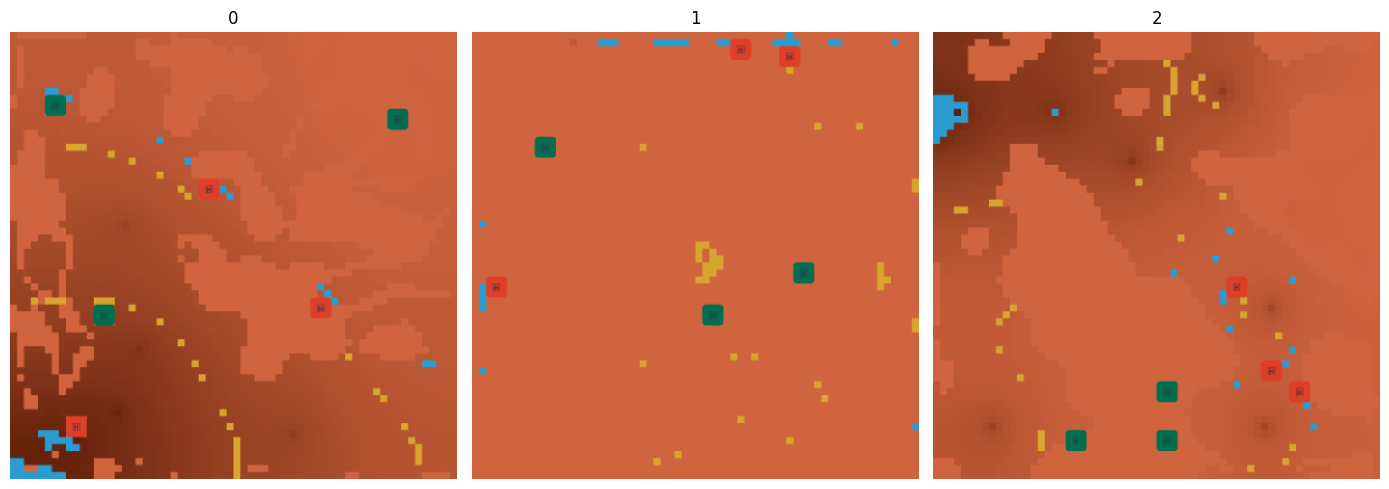

factories_per_team Traced<ShapedArray(int8[32])>with<DynamicJaxprTrace(level=1/0)>

i= 0 , 97.0 / 976.0

__ 270 s

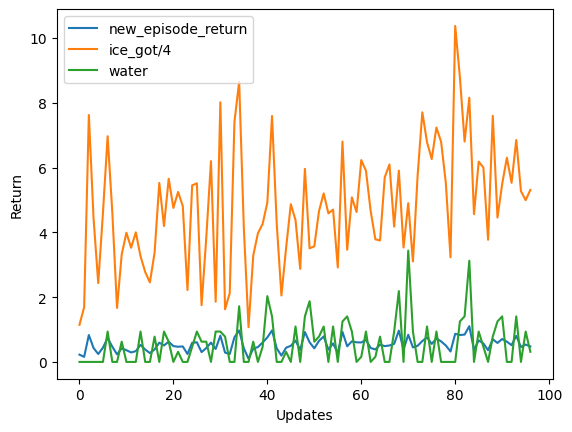

i= 1 , 194.0 / 976.0

__ 411 s

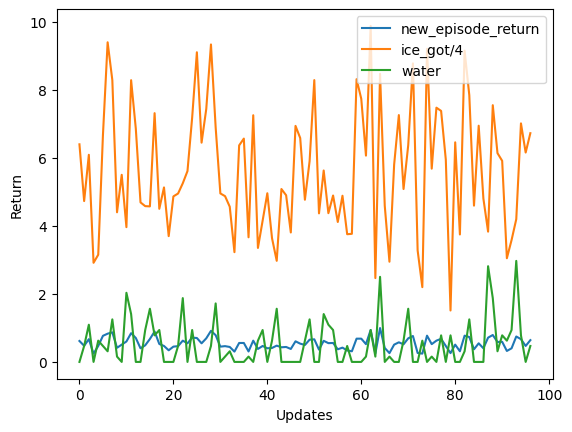

i= 2 , 291.0 / 976.0

__ 550 s

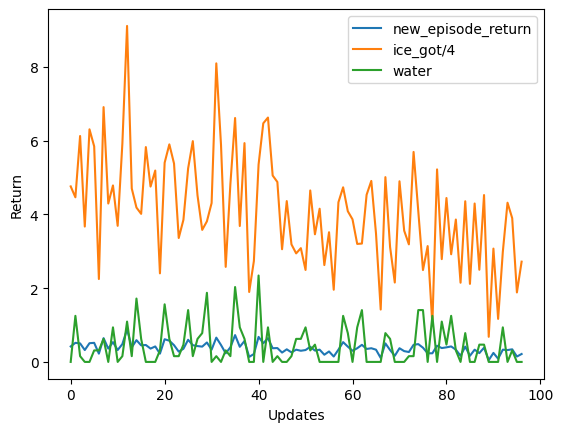

i= 3 , 388.0 / 976.0

__ 690 s

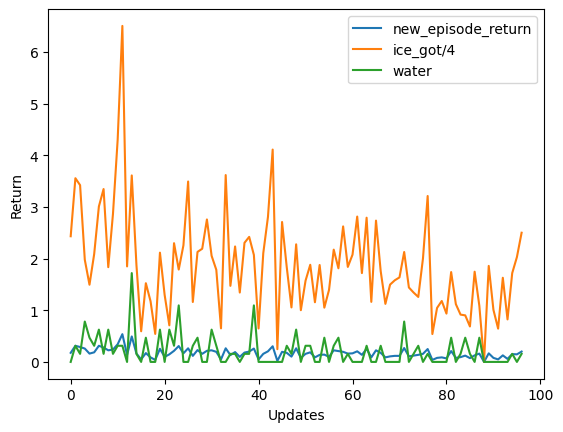

i= 4 , 485.0 / 976.0

__ 829 s

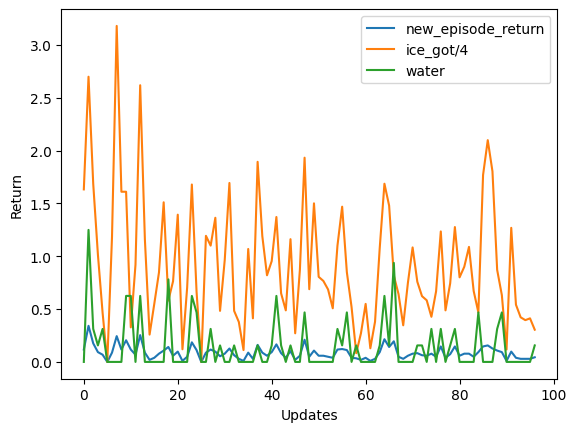

i= 5 , 582.0 / 976.0

__ 969 s

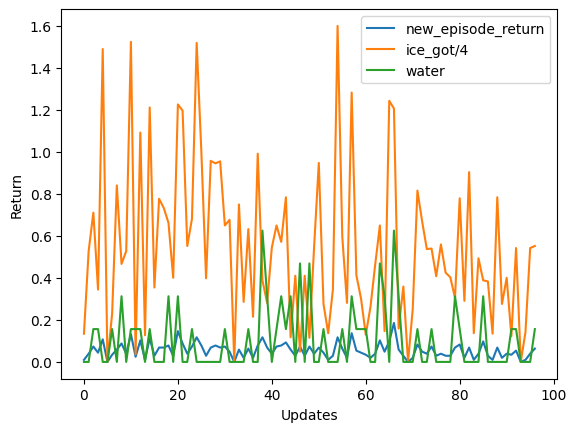

i= 6 , 679.0 / 976.0

__ 1108 s

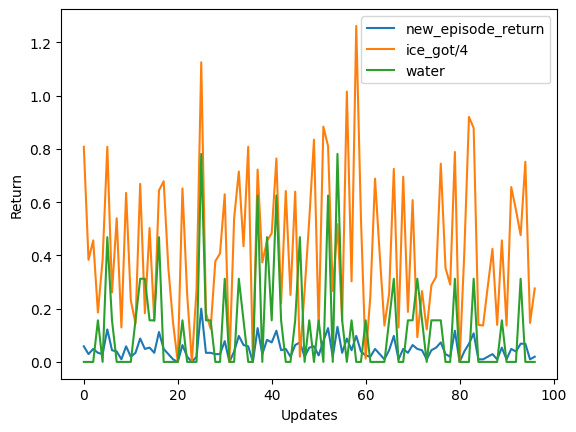

i= 7 , 776.0 / 976.0

__ 1248 s

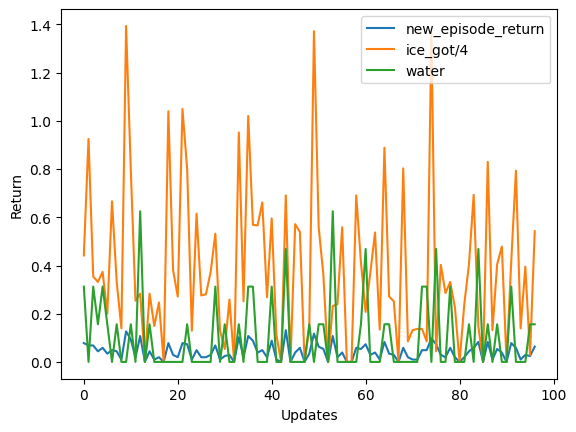

i= 8 , 873.0 / 976.0

__ 1387 s

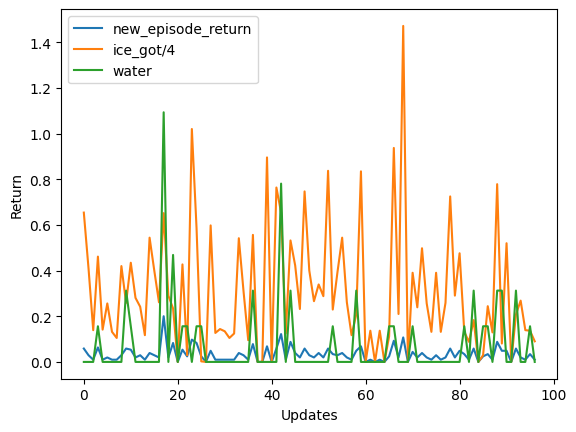

i= 9 , 970.0 / 976.0

__ 1527 s

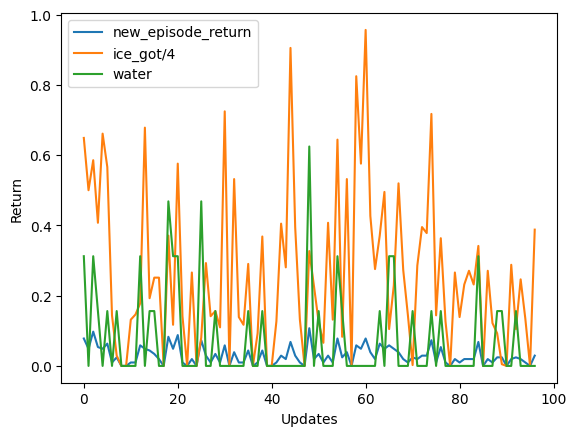

In [22]:
for i in range(1):
    stime = time.time()
    rng = jax.random.PRNGKey(62+i)
#     if i != 0:
#         raw_restored = orbax_checkpointer.restore(f'/kaggle/working/single_savetest_{i-1}')
    if raw_restored:
        if jit:
            train_jit = jax.jit(make_train(config, raw_restored))
        else:
            train_jit = make_train(config, raw_restored)
    else:
        if jit:
            train_jit = jax.jit(make_train(config))
        else:
            train_jit = make_train(config)

    out = train_jit(rng)
    if jit:
        save_args = orbax_utils.save_args_from_target(out)
        orbax_checkpointer.save(f'/kaggle/working/single_savetest_{i}', out, force=True, save_args=save_args)
        rich.print(f'step{i}, time, {round(time.time()-stime,0)}s')
        return_updates_per_step = out['metrics']['new_episode_return'].mean(-1).max(-1)/out['metrics']['timestep'].mean(-1).max(-1)
        rich.print('_____new_episode_return/step',
                   return_updates_per_step)
        water_updates = out['metrics']['episode_water'].mean(-1).max(-1)
        rich.print('_____episode_water',
                   water_updates)
        plt.plot(return_updates_per_step.reshape(-1))
        plt.plot(out["metrics"]["ice_got"].mean(-1).mean(-1).reshape(-1)/10)
        plt.plot(water_updates.reshape(-1))
        plt.xlabel("Updates")
        plt.ylabel("Return")
        plt.legend(labels=(
            'new_episode_return',
            'ice_got/10',
            'water',
            ))
        plt.show()